<h3> NBA 5 year careeer prediction using XBoost Classifier

In [1]:
import pandas as pd
import numpy as np

<h4> 1. Load processed sets

<h5> Loading scaled training, validation and test sets from data_prep step saved on the data/processed folder saving them into X_train, X_val, y_train, y_val, X_test, X_test_ID variables

In [2]:
#Load Test and validation sets using custom function load_sets
from src.data.sets import load_sets

In [3]:
X_train, X_val, y_train, y_val, X_test, X_test_ID = load_sets()

<h4> 2. Import XGBoost

<h5> Importing and fitting XGBoost Classifier specifying early_stopping_rounds=10 to stop the model after 10 iterations without improving in the predictions, n_estimators=200 and evaluation metric=aucpr to meassure the accuracy of the model vs the validation set

In [4]:
import xgboost as xgb

<h4> 2.1 Analyse features importance in random forest model with current training sets

In [5]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', 
                              #scale_pos_weight=0.1995, 
                              n_estimators=200, seed=42)

In [6]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(xgb_model)
sel.fit(X_train, y_train)

SelectFromModel(estimator=XGBClassifier(base_score=None, booster='gbtree',
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=200, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...))

<h4> 2.2 Finding the most relevant features in making predictions

<h5> After the model has been fitted, we use get.support to find out which features are most relevant in the predictions

In [7]:
columns = sel.get_support()
columns = columns.tolist()
columns

[True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False]

<h5> As column importance is given in order of appearance on the scaled set, importing column names saved in data_prep for easy visualization and identification will be performed

<h5> Importing predictor column names and combining with relevant columns to find out the best feature predictors

In [8]:
predictors  = pd.read_csv('../data/interim/predictor_names.csv')

In [9]:
predictors['Relevant_Feature'] = columns

In [10]:
predictors

,names,Relevant_Feature
0,GP,True
1,MIN,False
2,PTS,True
3,FGM,False
4,FGA,False
5,FG%,False
6,3P Made,False
7,3PA,False
8,3P%,True
9,FTM,True


In [11]:
predictors.loc[predictors['Relevant_Feature'] == 1]

,names,Relevant_Feature
0,GP,True
2,PTS,True
8,3P%,True
9,FTM,True
12,OREB,True
16,STL,True


<h5> <b>CONCLUSION ON PREDICTORS: </b> Based on the rebalanced training set from data_prep, 6 features are the most relevant predictors. Therefore new data prep will be generated for usage of these columns within the model

<h4> 2.3 New data prep to be performed and data sets saved in the ../data/interim folder

<h5> 2.3.1 Get a list of column names to be removed from data set

In [12]:
columns_to_remove_df = predictors.loc[predictors['Relevant_Feature'] == 0]

In [13]:
columns_to_remove = columns_to_remove_df.pop("names")

In [14]:
columns_to_remove_list = columns_to_remove.values.tolist()

<h5> 2.3.2 Read csvs and remove unwanted columns

In [15]:
df = pd.read_csv('../data/raw/2022_train.csv')

In [16]:
df_cleaned = df.copy()
df_cleaned.drop(columns=columns_to_remove_list, axis=1, inplace=True)
df_cleaned.drop("Id", axis=1, inplace=True)

In [17]:
df_cleaned.head()

,GP,PTS,3P%,FTM,OREB,STL,TARGET_5Yrs
0,80,7.8,22.6,2.0,2.2,1.1,1
1,75,10.5,34.9,2.4,3.6,0.5,1
2,85,4.5,34.3,0.4,0.6,0.4,1
3,63,8.2,23.7,0.9,0.8,0.4,1
4,63,3.7,13.7,0.2,2.4,0.4,1


<h5> 2.3.3 Rebalance imbalance set with custom function

<h5> This function will undersample the mayority class to have the same number of observations of the minority class. <br> <br> This function is saved in the src folder

In [18]:
from src.data.sets import rebalance_mayority_class

In [19]:
df_rebalanced = df_cleaned.copy()

In [20]:
#df_rebalanced = rebalance_mayority_class(df_cleaned, "TARGET_5Yrs")

<h5> 2.3.4 Scaling and generating training and validation set

<h5> The rebalanced data set will be split into training and validation set for fitting and evaluation of the XGB classifier model <br><br> The rebalancing will be performed with a custom function saved in the src folder

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [22]:
target = df_rebalanced.pop("TARGET_5Yrs")

In [23]:
df_rebalanced_clean = scaler.fit_transform(df_rebalanced)

In [24]:
#Import subset function for getting training and valudation sets
from src.data.sets import subset_x_y

In [25]:
X_train, X_val, y_train, y_val = subset_x_y(df_rebalanced_clean, target)

<h5> 2.3.5 Clean, transform and scale Test set

<h5> This step will clean, trasnform and scale the test data set with the same steps from the training set

In [26]:
df_test = pd.read_csv('../data/raw/2022_test.csv')

In [27]:
X_test_ID = df_test.pop('Id')

In [28]:
X_test = df_test.copy()

In [29]:
X_test.drop(columns=columns_to_remove_list, axis=1, inplace=True)

In [30]:
X_test = scaler.fit_transform(X_test)

<h5> 2.3.6 Save train, evaluate and test sets in ../data/interim folder

<h5> Finally, all cleaned and transfor sets will be saved in the data/interim folder using a custom function saved in the src folder

In [31]:
from src.data.sets import save_sets_interim

In [32]:
save_sets_interim(X_train, X_val, y_train, y_val, X_test, X_test_ID)

<h4> 3 Train XGB Classifier with new calculated training sets

<h5> Next up, the XGB classifier will be imported and trained with the new training set and saved into the models folder

In [33]:
xgb_model.fit(X_train, y_train , early_stopping_rounds=10, 
              eval_metric='aucpr', eval_set=[(X_val,y_val)])

[0]	validation_0-aucpr:0.89905
[1]	validation_0-aucpr:0.90015
[2]	validation_0-aucpr:0.90405
[3]	validation_0-aucpr:0.90308
[4]	validation_0-aucpr:0.89981
[5]	validation_0-aucpr:0.90100
[6]	validation_0-aucpr:0.90113
[7]	validation_0-aucpr:0.89915
[8]	validation_0-aucpr:0.90093
[9]	validation_0-aucpr:0.89783
[10]	validation_0-aucpr:0.89823
[11]	validation_0-aucpr:0.89930


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

<h5> After the model has been fitted, it will be saved in the models folder in case it needs to be re-called on a later process

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
#Save model in the models folder
from joblib import dump
dump(xgb_model, '../models/XGBoost.joblib')

['../models/XGBoost.joblib']

<h4> 3.1 Generate predictions for training and validation sets in order to compare accuracy vs Baseline

<h5> The fitted model will be used to predict the validation set and accuracy willl be calculated to compare vs the baseline

In [36]:
y_val_preds = xgb_model.predict(X_val)

In [37]:
y_trainpreds = xgb_model.predict(X_train)

In [38]:
accuracy = accuracy_score(y_val, y_val_preds)
accuracy

0.82625

<h4> 3.2 Calculate mse and mae to assess fiting accuracy for the training and validation sets

In [39]:
#Get error/score metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [40]:
print(mse(y_train, y_trainpreds, squared=False))
print(mae(y_train, y_trainpreds))

0.39071249020219456
0.15265625


In [41]:
print(mse(y_val, y_val_preds, squared=False))
print(mae(y_val, y_val_preds))

0.41683330001332664
0.17375


In [42]:
xgb_model.score(X_train, y_train)

0.84734375

In [43]:
xgb_model.score(X_val, y_val)

0.82625

<h4> 3 Analysis of the validation set

<h5> Analysis of the results will be done through a confusion matrix to gather insights as to where the accuracy/innacuracy exists in order to improve the model in future experiments

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

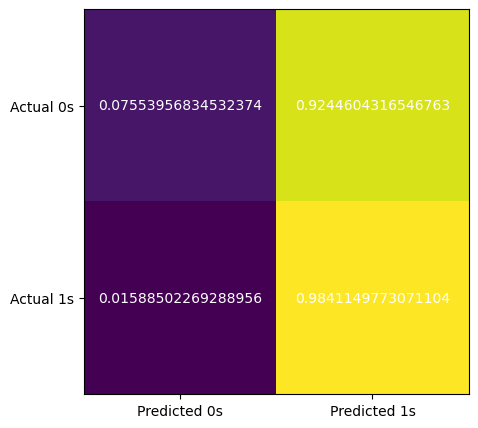

In [45]:
cm = confusion_matrix(y_val, y_val_preds, normalize='true')

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

<h4> 4 Generate predictions on the test set for Kaggle submission

<h5> The final step is to generate the prediction probabilities from the test set in order to evaluate the score from Kaggle via csv upload

In [46]:
y_test_preds = xgb_model.predict_proba(X_test)

In [47]:
#Create Data Frame for Doc printing
df =pd.DataFrame()

In [48]:
y_test_preds


array([[0.27799553, 0.7220045 ],
       [0.3306728 , 0.6693272 ],
       [0.21919286, 0.78080714],
       ...,
       [0.30201352, 0.6979865 ],
       [0.30194706, 0.69805294],
       [0.3459068 , 0.6540932 ]], dtype=float32)

In [49]:
target_prob = y_test_preds
target_prob = [item[1] for item in y_test_preds]

In [50]:
df['Id'] = X_test_ID
df['TARGET_5Yrs'] = target_prob

In [51]:
df.head()

,Id,TARGET_5Yrs
0,0,0.722004
1,1,0.669327
2,2,0.780807
3,3,0.790917
4,4,0.700083


In [52]:
#Saving predictions into csv
df.to_csv('../data/external/Kaggle_submission_XGBoost.csv', index=False)